In [1]:
idx = 20

In [2]:
import sys
sys.path.append("..") 
sys.path.append("../..") 
import torch
from models.components.ldm.denoiser import UNetModel
import numpy as np
import torch.nn.functional as F
import json

import hydra
from LDM_conditional.DownscalingDataModule import DownscalingDataModule
from LDM_conditional.models.unet_module import DownscalingUnet
from LDM_conditional.models.ae_module import AutoencoderKL
from LDM_conditional.models.ldm_module import LatentDiffusion
from LDM_conditional.models.components.ldm.denoiser import DDIMSampler
from omegaconf import DictConfig
import paths

ValueError: Key backend: 'module://matplotlib_inline.backend_inline' is not a valid value for backend; supported values are ['gtk3agg', 'gtk3cairo', 'gtk4agg', 'gtk4cairo', 'macosx', 'nbagg', 'notebook', 'qtagg', 'qtcairo', 'qt5agg', 'qt5cairo', 'tkagg', 'tkcairo', 'webagg', 'wx', 'wxagg', 'wxcairo', 'agg', 'cairo', 'pdf', 'pgf', 'ps', 'svg', 'template']

In [ ]:
import seaborn as sns
sns.set() 
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
from models.unet_module import DownscalingUnetLightning 
from models.ae_module import AutoencoderKL
from models.components.ae import SimpleConvEncoder, SimpleConvDecoder
from models.components.ldm.denoiser.ddim import DDIMSampler
from models.ldm_module import LatentDiffusion
from DownscalingDataModule import DownscalingDataModule

Dataloaders

In [ ]:
# Define train and val input/target paths (update file paths as needed)
train_input_paths = {
    'precip': paths.DATASETS_TRAINING_DIR + "/RhiresD_input_train_scaled.nc",
    'temp': paths.DATASETS_TRAINING_DIR + "/TabsD_input_train_scaled.nc",
    'temp_min': paths.DATASETS_TRAINING_DIR + "/TminD_input_train_scaled.nc",
    'temp_max': paths.DATASETS_TRAINING_DIR + "/TmaxD_input_train_scaled.nc"
}
train_target_paths = {
    'precip': paths.DATASETS_TRAINING_DIR + "/RhiresD_target_train_scaled.nc",
    'temp': paths.DATASETS_TRAINING_DIR + "/TabsD_target_train_scaled.nc",
    'temp_min': paths.DATASETS_TRAINING_DIR + "/TminD_target_train_scaled.nc",
    'temp_max': paths.DATASETS_TRAINING_DIR + "/TmaxD_target_train_scaled.nc"
}
val_input_paths = {
    'precip': paths.DATASETS_TRAINING_DIR + "/RhiresD_input_val_scaled.nc",
    'temp': paths.DATASETS_TRAINING_DIR + "/TabsD_input_val_scaled.nc",
    'temp_min': paths.DATASETS_TRAINING_DIR + "/TminD_input_val_scaled.nc",
    'temp_max': paths.DATASETS_TRAINING_DIR + "/TmaxD_input_val_scaled.nc"
}
val_target_paths = {
    'precip': paths.DATASETS_TRAINING_DIR + "/RhiresD_target_val_scaled.nc",
    'temp': paths.DATASETS_TRAINING_DIR + "/TabsD_target_val_scaled.nc",
    'temp_min': paths.DATASETS_TRAINING_DIR + "/TminD_target_val_scaled.nc",
    'temp_max': paths.DATASETS_TRAINING_DIR + "/TmaxD_target_val_scaled.nc"
}

test_input_paths= {
    'precip': paths.DATASETS_TRAINING_DIR + "/RhiresD_input_test_scaled.nc",
    'temp': paths.DATASETS_TRAINING_DIR + "/TabsD_input_test_scaled.nc",
    'temp_min': paths.DATASETS_TRAINING_DIR + "/TminD_input_test_scaled.nc",
    'temp_max': paths.DATASETS_TRAINING_DIR + "/TmaxD_input_test_scaled.nc"
}

test_target_paths = {
    'precip': paths.DATASETS_TRAINING_DIR + "/RhiresD_target_test_scaled.nc",
    'temp': paths.DATASETS_TRAINING_DIR + "/TabsD_target_test_scaled.nc",
    'temp_min': paths.DATASETS_TRAINING_DIR + "/TminD_target_test_scaled.nc",
    'temp_max': paths.DATASETS_TRAINING_DIR + "/TmaxD_target_test_scaled.nc"
}


In [137]:
elevation_path = '/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/elevation.tif'

In [138]:
dm = DownscalingDataModule(
    train_input=train_input_paths,
    train_target=train_target_paths,
    val_input=val_input_paths,
    val_target=val_target_paths,
    test_input=test_input_paths,
    test_target=test_target_paths,
    elevation=elevation_path,
    batch_size=32,
    num_workers=4,
    preprocessing={
        'variables': {
            'input': {
                'precip': 'RhiresD',
                'temp': 'TabsD',
                'temp_min': 'TminD',
                'temp_max': 'TmaxD'
            },
            'target': {
                'precip': 'RhiresD',
                'temp': 'TabsD',
                'temp_min': 'TminD',
                'temp_max': 'TmaxD'
            }
        },
        'preprocessing': {
            'nan_to_num': True,
            'nan_value': 0.0
        }
    }
)
dm.setup()


In [139]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()

In [140]:
train_inputs, train_targets = next(iter(train_loader))
val_inputs, val_targets = next(iter(val_loader))
test_inputs, test_targets = next(iter(test_loader))

1. Plotting Unet pred for idex = idx

In [141]:
ckpt_unet = paths.LDM_DIR+"/trained_ckpts/10km/LDM_conditional.models.unet_module.DownscalingUnetLightning_checkpoint.ckpt"


In [142]:

model_UNet = DownscalingUnetLightning(
    in_ch=5,  # 4 vars + elevation
    out_ch=4,  # 4 output variables
    features=[64, 128, 256, 512],
    channel_names=["precip", "temp", "temp_min", "temp_max"]
)

In [143]:
unet_state_dict = torch.load(ckpt_unet, map_location="cpu")["state_dict"]
model_UNet.load_state_dict(unet_state_dict, strict=False)
model_UNet.eval()

DownscalingUnetLightning(
  (unet): DownscalingUnet(
    (encoder): ModuleList()
    (decoder): ModuleList()
    (e1): EncoderBlock(
      (conv): DoubleConv(
        (conv): Sequential(
          (0): Conv2d(5, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ReLU()
        )
      )
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (e2): EncoderBlock(
      (conv): DoubleConv(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2)

In [144]:
with open(paths.DATASETS_TRAINING_DIR + "/RhiresD_scaling_params.json", 'r') as f:
    pr_params = json.load(f)
with open(paths.DATASETS_TRAINING_DIR + "/TabsD_scaling_params.json", 'r') as f:
    temp_params = json.load(f)
with open(paths.DATASETS_TRAINING_DIR + "/TminD_scaling_params.json", 'r') as f:
    temp_min_params = json.load(f)
with open(paths.DATASETS_TRAINING_DIR + "/TmaxD_scaling_params.json", 'r') as f:
    temp_max_params = json.load(f)

def denorm_pr(x):

    return np.exp(x * pr_params['std'] + pr_params['mean']) - pr_params['epsilon']

def denorm_temp(x, params):

    return x * params['std'] + params['mean']

In [145]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [146]:
UNet_model = model_UNet.to(device)

#VAE encoding residuals 

In [147]:
encoder= SimpleConvEncoder(in_dim=4, levels=2,min_ch=16,ch_mult=4)
decoder = SimpleConvDecoder(in_dim=64, levels=2, min_ch=16, out_dim=4, ch_mult=4)

normalization called with channels=4, norm_type=group, norm_kwargs={'num_groups': 1}
normalization called with channels=16, norm_type=group, norm_kwargs={'num_groups': 1}
normalization called with channels=16, norm_type=group, norm_kwargs={'num_groups': 1}
normalization called with channels=64, norm_type=group, norm_kwargs={'num_groups': 1}
normalization called with channels=256, norm_type=group, norm_kwargs={'num_groups': 1}
normalization called with channels=256, norm_type=group, norm_kwargs={'num_groups': 1}
normalization called with channels=4, norm_type=group, norm_kwargs={'num_groups': 1}
normalization called with channels=4, norm_type=group, norm_kwargs={'num_groups': 1}


In [148]:
unet_regr= DownscalingUnetLightning(in_ch=5,
                                    out_ch=4,
                                    features=[64, 128, 256, 512],
                                    channel_names=["precip", "temp", "temp_min", "temp_max"])

In [149]:
unet_regr_ckpt = torch.load(paths.LDM_DIR+"/trained_ckpts/10km/LDM_conditional.models.unet_module.DownscalingUnetLightning_checkpoint.ckpt",
                            map_location="cpu"
)["state_dict"]

In [150]:
unet_regr.load_state_dict(unet_regr_ckpt, strict=False) #Loading it second time for regression network inside VAE
unet_regr.eval()

DownscalingUnetLightning(
  (unet): DownscalingUnet(
    (encoder): ModuleList()
    (decoder): ModuleList()
    (e1): EncoderBlock(
      (conv): DoubleConv(
        (conv): Sequential(
          (0): Conv2d(5, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ReLU()
        )
      )
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (e2): EncoderBlock(
      (conv): DoubleConv(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2)

Instantiating VAE

In [151]:
vae_model= AutoencoderKL(encoder=encoder, decoder=decoder, 
                         kl_weight=0.01,
                         ae_flag="residual",
                         unet_regr=unet_regr)

In [152]:
vae_ckpt = torch.load(paths.LDM_DIR+
    "/trained_ckpts/10km/LDM_conditional.models.ae_module.AutoencoderKL_checkpoint.ckpt",
    map_location="cpu"
)["state_dict"]
vae_model.load_state_dict(vae_ckpt, strict=False)
vae_model = vae_model.to(device)
vae_model.eval()

AutoencoderKL(
  (encoder): SimpleConvEncoder(
    (net): Sequential(
      (0): ResBlock2D(
        (proj): Conv2d(4, 16, kernel_size=(1, 1), stride=(1, 1))
        (conv1): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (act1): SiLU()
        (act2): SiLU()
        (norm1): GroupNorm(1, 4, eps=1e-05, affine=True)
        (norm2): GroupNorm(1, 16, eps=1e-05, affine=True)
        (sequence): Sequential(
          (0): GroupNorm(1, 4, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (3): GroupNorm(1, 16, eps=1e-05, affine=True)
          (4): SiLU()
          (5): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
      (1): Conv2d(16, 16, kernel_size=(2, 2), stride=(2, 2))
      (2): ResBlock2D(
        (proj): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))


Loading LDM ckp

In [153]:
# Instantiate the context conditioner
from models.components.ldm.conditioner import AFNOConditionerNetCascade

conditioner = AFNOConditionerNetCascade(
    autoencoder=vae_model,
    embed_dim=[64, 128, 256, 256],
    analysis_depth=4,
    cascade_depth=4,
    context_ch=[64, 128, 256, 256]
)

normalization called with channels=64, norm_type=group, norm_kwargs={'num_groups': 8}
normalization called with channels=128, norm_type=group, norm_kwargs={'num_groups': 8}
normalization called with channels=128, norm_type=group, norm_kwargs={'num_groups': 8}
normalization called with channels=256, norm_type=group, norm_kwargs={'num_groups': 8}
normalization called with channels=256, norm_type=group, norm_kwargs={'num_groups': 8}
normalization called with channels=512, norm_type=group, norm_kwargs={'num_groups': 8}


In [154]:
# denoiser UNet
from models.components.ldm.denoiser.unet import UNetModel

denoiser = UNetModel(
    model_channels=64,
    in_channels=32,
    out_channels=32,
    num_res_blocks=2,
    attention_resolutions=[1, 2, 4],
    context_ch=[64, 128, 256, 256],
    channel_mult=[1, 2, 4, 4],
    conv_resample=True,
    dims=2,
    use_fp16=False,
    num_heads=4
)



In [155]:
from models.ldm_module import LatentDiffusion

ldm = LatentDiffusion(
    denoiser=denoiser,
    autoencoder=vae_model,
    context_encoder=conditioner,
    timesteps=1000,
    parameterization="v",
    loss_type="l2"
)

# 5. Load the trained LDM checkpoint
ldm_ckpt = torch.load(paths.LDM_DIR+
    "/trained_ckpts/10km/LDM_checkpoint_V1_linear_schedule_250_steps.ckpt",
    map_location=device
)
ldm.load_state_dict(ldm_ckpt["state_dict"], strict=False)

# Set to eval mode and move to device
ldm = ldm.to(device)
ldm.eval()

LatentDiffusion(
  (denoiser): UNetModel(
    (time_embed): Sequential(
      (0): Linear(in_features=64, out_features=256, bias=True)
      (1): SiLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
    )
    (input_blocks): ModuleList(
      (0): TimestepEmbedSequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1-2): 2 x TimestepEmbedSequential(
        (0): ResBlock(
          (in_layers): Sequential(
            (0): Identity()
            (1): SiLU()
            (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (emb_layers): Sequential(
            (0): SiLU()
            (1): Linear(in_features=256, out_features=64, bias=True)
          )
          (out_layers): Sequential(
            (0): Identity()
            (1): SiLU()
            (2): Dropout(p=0, inplace=False)
            (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
      

In [156]:
from models.components.ldm.denoiser.ddim import DDIMSampler

#UNet prediction and compute normalized residual
with torch.no_grad():
    input_sample = test_inputs[idx].unsqueeze(0).to(device)   # (1, 5, H, W)
    unet_pred = UNet_model(input_sample)                      # (1, 4, H, W)
    latent_shape = (1, 32, unet_pred.shape[2] // 4, unet_pred.shape[3] // 4)
    z = torch.randn(latent_shape, device=device)


# context using the conditioner
with torch.no_grad():
    # The conditioner expects a list of tuples: [(coarse_pred, None)]
    context = conditioner([(unet_pred, None)])  # List of context tensors per scale
    


Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])


In [157]:
# With this for prior/generative sampling:
with torch.no_grad():
    # Use the UNet output to determine spatial dims
    latent_shape = (1, 32, unet_pred.shape[2] // 4, unet_pred.shape[3] // 4)
    z = torch.randn(latent_shape, device=device)

In [158]:
# Denoise using DDIMSampler, conditioned on context
sampler = DDIMSampler(ldm, device=device)
latent_shape = z.shape[1:]  # (latent_ch, H, W)
S = 250  # Number of DDIM steps (as in your config)

conditioning = [(unet_pred, None)]
sampled_latent, _ = sampler.sample(
    S=S,
    batch_size=1,
    shape=latent_shape,
    conditioning=conditioning,
    eta=0.0,
    verbose=True,
    x_T=z, 
)

with torch.no_grad():
    generated_residual = vae_model.decode(sampled_latent)

    # Crop generated_residual to match unet_pred shape if needed
    if generated_residual.shape != unet_pred.shape:
        # Only crop spatial dims (assume NCHW)
        _, _, h1, w1 = unet_pred.shape
        _, _, h2, w2 = generated_residual.shape
        crop_h = min(h1, h2)
        crop_w = min(w1, w2)
        # Center crop generated_residual to match unet_pred
        start_h = (h2 - crop_h) // 2
        start_w = (w2 - crop_w) // 2
        generated_residual = generated_residual[:, :, start_h:start_h+crop_h, start_w:start_w+crop_w]
        # If unet_pred is larger, crop it too
        if h1 != crop_h or w1 != crop_w:
            start_h_u = (h1 - crop_h) // 2
            start_w_u = (w1 - crop_w) // 2
            unet_pred = unet_pred[:, :, start_h_u:start_h_u+crop_h, start_w_u:start_w_u+crop_w]

final_pred = unet_pred + generated_residual


Selected timesteps for ddim sampler: [  1   5   9  13  17  21  25  29  33  37  41  45  49  53  57  61  65  69
  73  77  81  85  89  93  97 101 105 109 113 117 121 125 129 133 137 141
 145 149 153 157 161 165 169 173 177 181 185 189 193 197 201 205 209 213
 217 221 225 229 233 237 241 245 249 253 257 261 265 269 273 277 281 285
 289 293 297 301 305 309 313 317 321 325 329 333 337 341 345 349 353 357
 361 365 369 373 377 381 385 389 393 397 401 405 409 413 417 421 425 429
 433 437 441 445 449 453 457 461 465 469 473 477 481 485 489 493 497 501
 505 509 513 517 521 525 529 533 537 541 545 549 553 557 561 565 569 573
 577 581 585 589 593 597 601 605 609 613 617 621 625 629 633 637 641 645
 649 653 657 661 665 669 673 677 681 685 689 693 697 701 705 709 713 717
 721 725 729 733 737 741 745 749 753 757 761 765 769 773 777 781 785 789
 793 797 801 805 809 813 817 821 825 829 833 837 841 845 849 853 857 861
 865 869 873 877 881 885 889 893 897 901 905 909 913 917 921 925 929 933
 937 941 945 9

DDIM Sampler:   0%|          | 0/250 [00:00<?, ?it/s]

DDIM Sampler:   1%|          | 3/250 [00:00<00:11, 21.92it/s]

Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFN

DDIM Sampler:   2%|▏         | 6/250 [00:00<00:11, 21.72it/s]

AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60

DDIM Sampler:   4%|▎         | 9/250 [00:00<00:11, 21.85it/s]

AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])


DDIM Sampler:   5%|▍         | 12/250 [00:00<00:10, 22.19it/s]

Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFN

DDIM Sampler:   6%|▌         | 15/250 [00:00<00:10, 22.18it/s]

AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 3

DDIM Sampler:   7%|▋         | 18/250 [00:00<00:10, 22.16it/s]

AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])


DDIM Sampler:   8%|▊         | 21/250 [00:00<00:10, 22.33it/s]

Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFN

DDIM Sampler:  10%|▉         | 24/250 [00:01<00:10, 22.35it/s]

AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet for

DDIM Sampler:  11%|█         | 27/250 [00:01<00:09, 22.41it/s]

AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
U

DDIM Sampler:  12%|█▏        | 30/250 [00:01<00:09, 22.46it/s]

AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 8, 12, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 8, 12, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1,

DDIM Sampler:  13%|█▎        | 33/250 [00:01<00:09, 22.48it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y

DDIM Sampler:  14%|█▍        | 36/250 [00:01<00:09, 22.57it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO 

DDIM Sampler:  16%|█▌        | 39/250 [00:01<00:09, 22.58it/s]

AFNO norm1(x) shape: torch.Size([1, 8, 12, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 8, 12, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60

DDIM Sampler:  17%|█▋        | 42/250 [00:01<00:09, 22.42it/s]

Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFN

DDIM Sampler:  18%|█▊        | 45/250 [00:02<00:09, 22.48it/s]

Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFN

DDIM Sampler:  19%|█▉        | 48/250 [00:02<00:08, 22.52it/s]

AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 3

DDIM Sampler:  20%|██        | 51/250 [00:02<00:08, 22.59it/s]

AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 8, 12, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 8, 12, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1,

DDIM Sampler:  22%|██▏       | 54/250 [00:02<00:08, 22.60it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y

DDIM Sampler:  23%|██▎       | 57/250 [00:02<00:08, 22.65it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y

DDIM Sampler:  24%|██▍       | 60/250 [00:02<00:08, 22.63it/s]

AFNO norm1(x) shape: torch.Size([1, 8, 12, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 8, 12, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60

DDIM Sampler:  25%|██▌       | 63/250 [00:02<00:08, 22.64it/s]

Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFN

DDIM Sampler:  26%|██▋       | 66/250 [00:02<00:08, 22.69it/s]

Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFN

DDIM Sampler:  29%|██▉       | 72/250 [00:03<00:07, 22.62it/s]

AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
U

DDIM Sampler:  30%|███       | 75/250 [00:03<00:07, 22.61it/s]

AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 8, 12, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 8, 12, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1,

DDIM Sampler:  32%|███▏      | 81/250 [00:03<00:07, 22.69it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO 

DDIM Sampler:  34%|███▎      | 84/250 [00:03<00:07, 22.62it/s]

AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60

DDIM Sampler:  35%|███▍      | 87/250 [00:03<00:07, 22.61it/s]

AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 8, 12, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 8, 12, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 

DDIM Sampler:  36%|███▌      | 90/250 [00:04<00:07, 22.64it/s]

Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFN

DDIM Sampler:  37%|███▋      | 93/250 [00:04<00:06, 22.59it/s]

AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet for

DDIM Sampler:  38%|███▊      | 96/250 [00:04<00:06, 22.58it/s]

AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet for

DDIM Sampler:  40%|███▉      | 99/250 [00:04<00:06, 22.62it/s]

AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 8, 12, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 8, 12, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1,

DDIM Sampler:  41%|████      | 102/250 [00:04<00:06, 22.61it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y

DDIM Sampler:  42%|████▏     | 105/250 [00:04<00:06, 22.59it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y

DDIM Sampler:  43%|████▎     | 108/250 [00:04<00:06, 22.63it/s]

AFNO norm1(x) shape: torch.Size([1, 8, 12, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 8, 12, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60

DDIM Sampler:  44%|████▍     | 111/250 [00:04<00:06, 22.62it/s]

Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFN

DDIM Sampler:  46%|████▌     | 114/250 [00:05<00:06, 22.57it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y

DDIM Sampler:  47%|████▋     | 117/250 [00:05<00:05, 22.58it/s]

AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 3

DDIM Sampler:  49%|████▉     | 123/250 [00:05<00:05, 22.72it/s]

AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 8, 12, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 8, 12, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1,

DDIM Sampler:  50%|█████     | 126/250 [00:05<00:05, 22.63it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y

DDIM Sampler:  53%|█████▎    | 132/250 [00:05<00:05, 22.58it/s]

AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 8, 12, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 8, 12, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 

DDIM Sampler:  54%|█████▍    | 135/250 [00:05<00:05, 22.54it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO 

DDIM Sampler:  56%|█████▋    | 141/250 [00:06<00:04, 22.54it/s]

AFNO norm1(x) shape: torch.Size([1, 8, 12, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 8, 12, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60

DDIM Sampler:  58%|█████▊    | 144/250 [00:06<00:04, 22.40it/s]

Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFN

DDIM Sampler:  60%|██████    | 150/250 [00:06<00:04, 22.64it/s]

AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
U

DDIM Sampler:  61%|██████    | 153/250 [00:06<00:04, 22.66it/s]

AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 8, 12, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 8, 12, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1,

DDIM Sampler:  64%|██████▎   | 159/250 [00:07<00:03, 22.78it/s]

Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFN

DDIM Sampler:  65%|██████▍   | 162/250 [00:07<00:03, 22.83it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y

DDIM Sampler:  66%|██████▌   | 165/250 [00:07<00:03, 22.87it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y

DDIM Sampler:  67%|██████▋   | 168/250 [00:07<00:03, 22.89it/s]

AFNO norm1(x) shape: torch.Size([1, 8, 12, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 8, 12, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60

DDIM Sampler:  68%|██████▊   | 171/250 [00:07<00:03, 22.89it/s]

Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFN

DDIM Sampler:  70%|██████▉   | 174/250 [00:07<00:03, 22.98it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y

DDIM Sampler:  71%|███████   | 177/250 [00:07<00:03, 22.97it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y

DDIM Sampler:  73%|███████▎  | 183/250 [00:08<00:02, 23.02it/s]

AFNO norm1(x) shape: torch.Size([1, 8, 12, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 8, 12, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60

DDIM Sampler:  74%|███████▍  | 186/250 [00:08<00:02, 22.92it/s]

Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFN

DDIM Sampler:  77%|███████▋  | 192/250 [00:08<00:02, 22.95it/s]

AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
U

DDIM Sampler:  78%|███████▊  | 195/250 [00:08<00:02, 22.92it/s]

AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 8, 12, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 8, 12, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 

DDIM Sampler:  79%|███████▉  | 198/250 [00:08<00:02, 22.93it/s]

AFNO norm1(x) shape: torch.Size([1, 8, 12, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 8, 12, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60

DDIM Sampler:  80%|████████  | 201/250 [00:08<00:02, 22.94it/s]

Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFN

DDIM Sampler:  82%|████████▏ | 204/250 [00:09<00:02, 22.91it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y

DDIM Sampler:  83%|████████▎ | 207/250 [00:09<00:01, 22.96it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y

DDIM Sampler:  84%|████████▍ | 210/250 [00:09<00:01, 22.97it/s]

AFNO norm1(x) shape: torch.Size([1, 8, 12, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 8, 12, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60

DDIM Sampler:  85%|████████▌ | 213/250 [00:09<00:01, 22.95it/s]

Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFN

DDIM Sampler:  86%|████████▋ | 216/250 [00:09<00:01, 23.00it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y

DDIM Sampler:  88%|████████▊ | 219/250 [00:09<00:01, 23.00it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y

DDIM Sampler:  90%|█████████ | 225/250 [00:09<00:01, 23.00it/s]

AFNO norm1(x) shape: torch.Size([1, 8, 12, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 8, 12, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60

DDIM Sampler:  91%|█████████ | 228/250 [00:10<00:00, 23.06it/s]

Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFN

DDIM Sampler:  94%|█████████▎| 234/250 [00:10<00:00, 23.11it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y

DDIM Sampler:  95%|█████████▍| 237/250 [00:10<00:00, 23.11it/s]

AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60

DDIM Sampler:  96%|█████████▌| 240/250 [00:10<00:00, 23.12it/s]

AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60

DDIM Sampler:  97%|█████████▋| 243/250 [00:10<00:00, 23.15it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 8, 12, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 8, 12, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 1

DDIM Sampler:  98%|█████████▊| 246/250 [00:10<00:00, 23.12it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y

DDIM Sampler: 100%|█████████▉| 249/250 [00:10<00:00, 23.12it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y

DDIM Sampler: 100%|██████████| 250/250 [00:11<00:00, 22.71it/s]

AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60

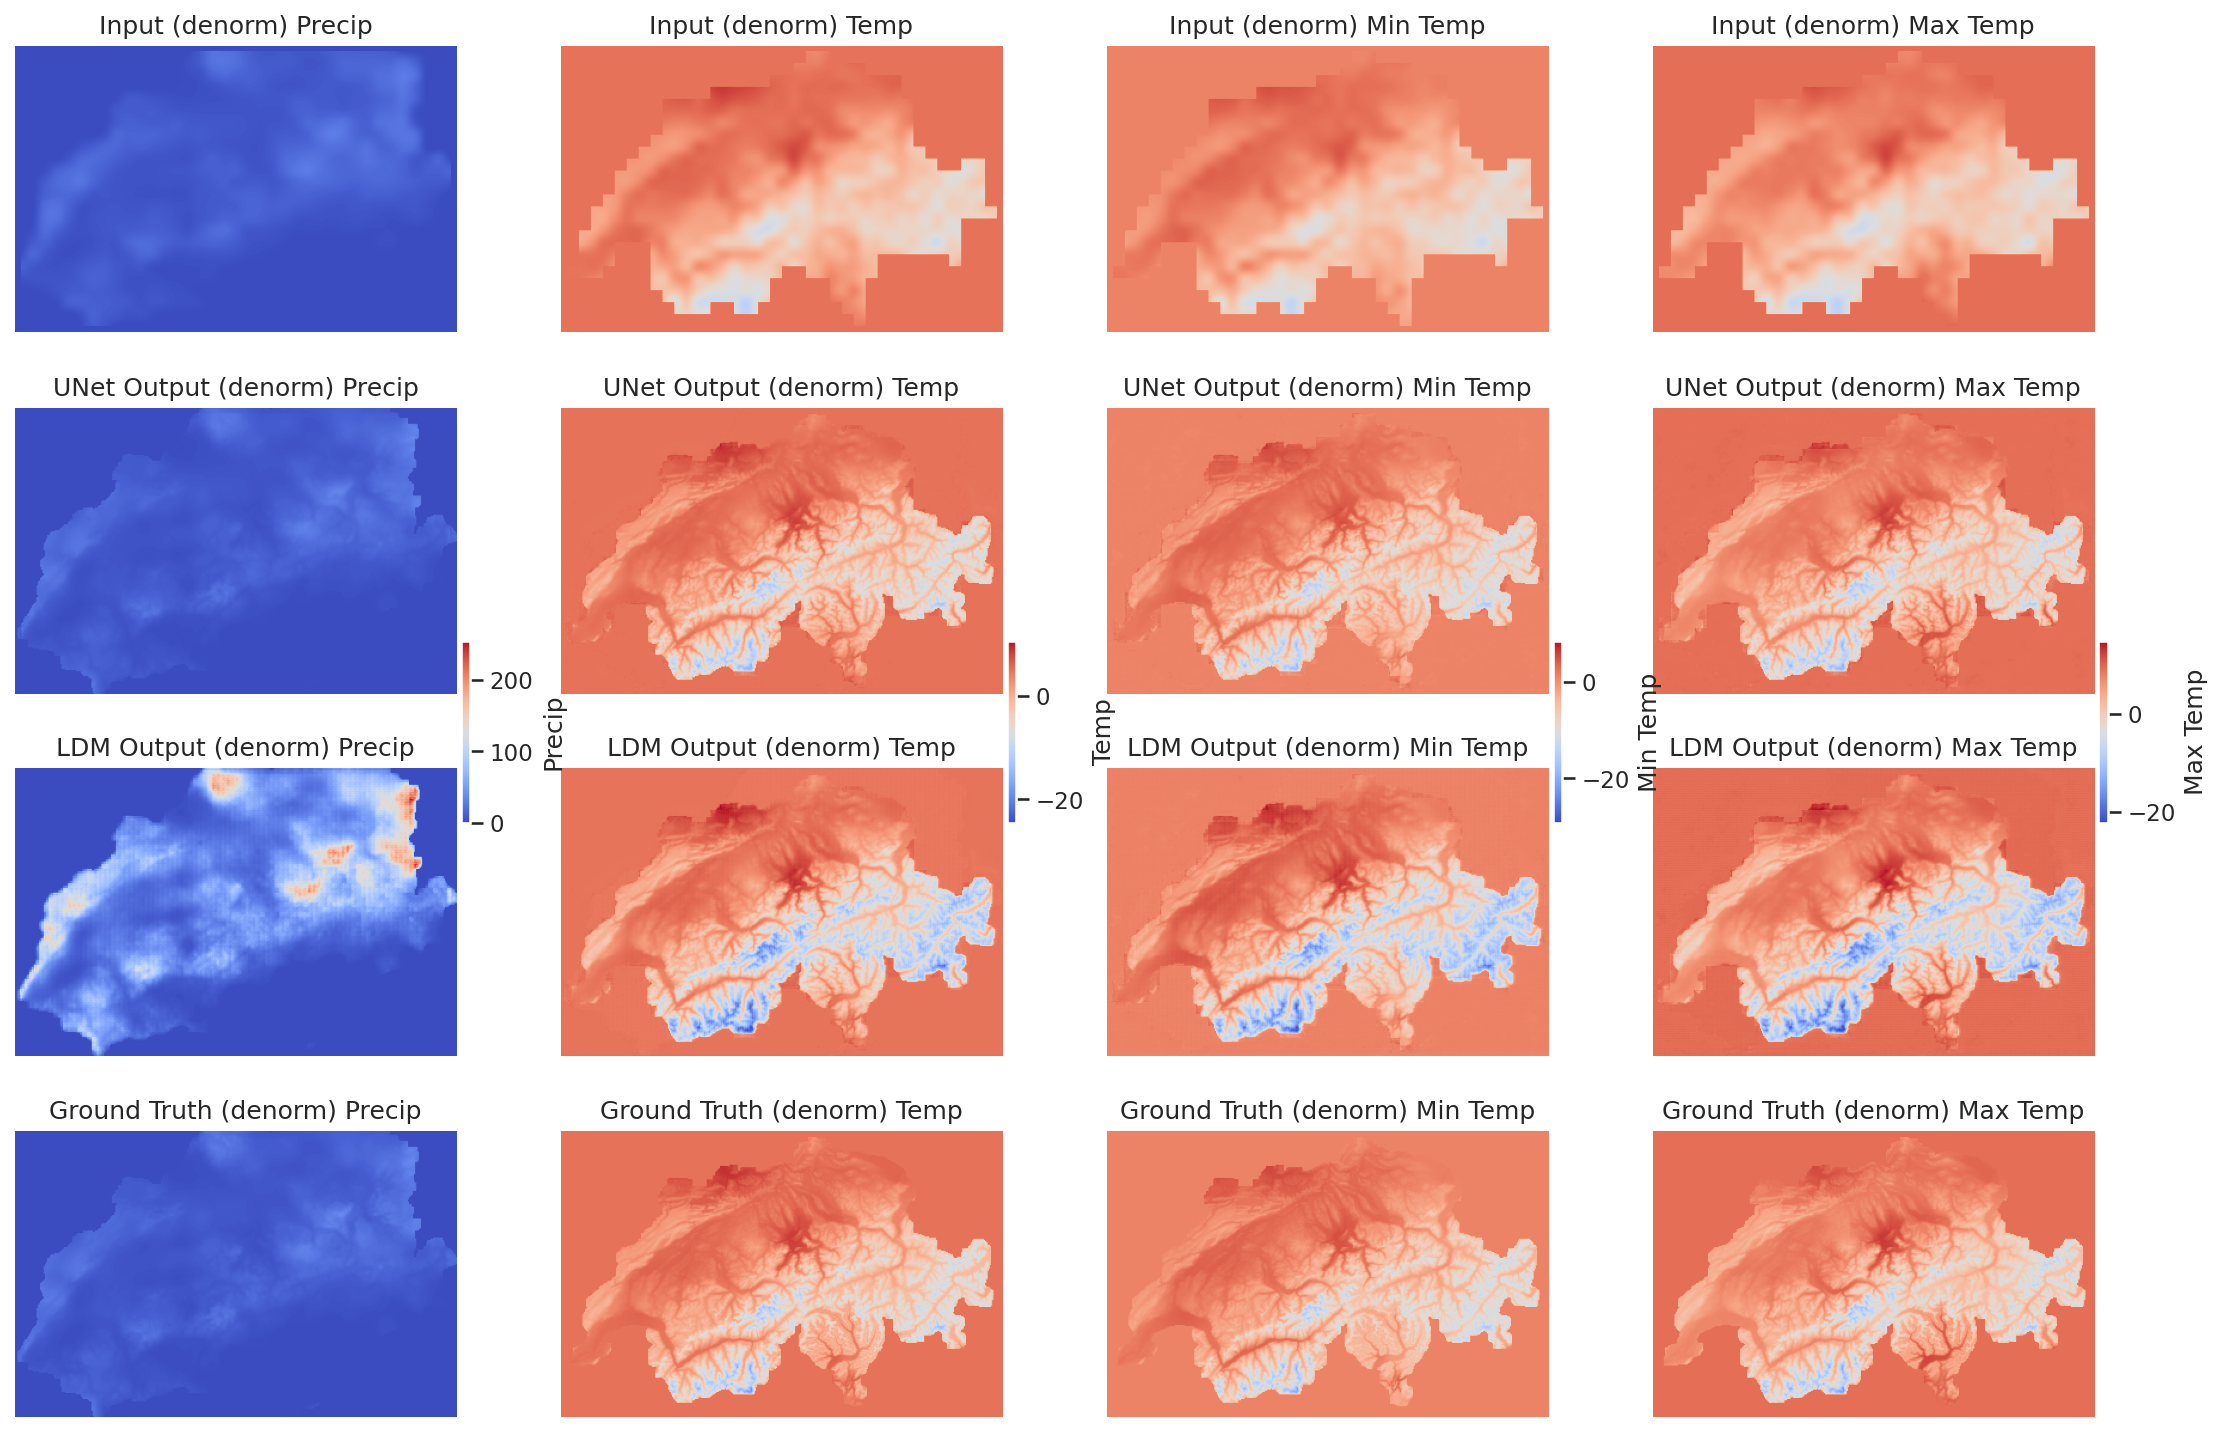

In [159]:
with torch.no_grad():
    input_sample = test_inputs[idx].unsqueeze(0).to(device)  # (1, 5, H, W)
    unet_pred = UNet_model(input_sample)                    # (1, 4, H, W)

    input_np = input_sample[0, :4].cpu().numpy()    # (4, H, W)
    unet_pred_np = unet_pred[0].cpu().numpy()       # (4, H, W)
    channel_names = ["Precip", "Temp", "Min Temp", "Max Temp"]

    # Denormalize input
    input_denorm = np.empty_like(input_np)
    for i, (var, params) in enumerate([
        ("precip", pr_params),
        ("temp", temp_params),
        ("temp_min", temp_min_params),
        ("temp_max", temp_max_params)
    ]):
        if var == "precip":
            input_denorm[i] = denorm_pr(input_np[i])
        else:
            input_denorm[i] = denorm_temp(input_np[i], params)

    # Denormalize UNet output
    unet_pred_denorm = np.empty_like(unet_pred_np)
    for i, (var, params) in enumerate([
        ("precip", pr_params),
        ("temp", temp_params),
        ("temp_min", temp_min_params),
        ("temp_max", temp_max_params)
    ]):
        if var == "precip":
            unet_pred_denorm[i] = denorm_pr(unet_pred_np[i])
        else:
            unet_pred_denorm[i] = denorm_temp(unet_pred_np[i], params)

    # Denormalize LDM output (final_pred)
    final_pred_np = final_pred[0].cpu().numpy()  # (4, H, W)
    ldm_pred_denorm = np.empty_like(final_pred_np)
    for i, (var, params) in enumerate([
        ("precip", pr_params),
        ("temp", temp_params),
        ("temp_min", temp_min_params),
        ("temp_max", temp_max_params)
    ]):
        if var == "precip":
            ldm_pred_denorm[i] = denorm_pr(final_pred_np[i])
        else:
            ldm_pred_denorm[i] = denorm_temp(final_pred_np[i], params)

    # Denormalize ground truth
    target_np = test_targets[idx].cpu().numpy()  # (4, H, W)
    target_denorm = np.empty_like(target_np)
    for i, (var, params) in enumerate([
        ("precip", pr_params),
        ("temp", temp_params),
        ("temp_min", temp_min_params),
        ("temp_max", temp_max_params)
    ]):
        if var == "precip":
            target_denorm[i] = denorm_pr(target_np[i])
        else:
            target_denorm[i] = denorm_temp(target_np[i], params)

    vmins = [min(input_denorm[j].min(), unet_pred_denorm[j].min(), ldm_pred_denorm[j].min(), target_denorm[j].min()) for j in range(4)]
    vmaxs = [max(input_denorm[j].max(), unet_pred_denorm[j].max(), ldm_pred_denorm[j].max(), target_denorm[j].max()) for j in range(4)]

    fig, axes = plt.subplots(4, 4, figsize=(18, 12), dpi=150)
    im_handles = []
    for j in range(4):
        im_handles.append(axes[0, j].imshow(np.flipud(input_denorm[j]), cmap='coolwarm', vmin=vmins[j], vmax=vmaxs[j]))
        axes[0, j].set_title(f"Input (denorm) {channel_names[j]}")
        axes[0, j].axis('off')
        axes[1, j].imshow(np.flipud(unet_pred_denorm[j]), cmap='coolwarm', vmin=vmins[j], vmax=vmaxs[j])
        axes[1, j].set_title(f"UNet Output (denorm) {channel_names[j]}")
        axes[1, j].axis('off')
        axes[2, j].imshow(np.flipud(ldm_pred_denorm[j]), cmap='coolwarm', vmin=vmins[j], vmax=vmaxs[j])
        axes[2, j].set_title(f"LDM Output (denorm) {channel_names[j]}")
        axes[2, j].axis('off')
        axes[3, j].imshow(np.flipud(target_denorm[j]), cmap='coolwarm', vmin=vmins[j], vmax=vmaxs[j])
        axes[3, j].set_title(f"Ground Truth (denorm) {channel_names[j]}")
        axes[3, j].axis('off')

    for j in range(4):
        cbar = fig.colorbar(axes[0, j].images[0], ax=axes[:, j], fraction=0.02, pad=0.01)
        cbar.ax.set_ylabel(channel_names[j])

    plt.show()